# Import

**Import:**
- complete review files are too large to process at once
- need to pull a sample of a few hundred thousand rows, then resample down to ~10 restaurants for the RAG

In [16]:
import sys
current_dir = "/Users/josephtolsma/Documents/dev/yelp_rag"
sys.path.insert(0,current_dir)

In [17]:
from src.config import DATA_DIR_RAW, DATA_DIR_SAMP
import pandas as pd
import os
import json
import numpy as np

In [18]:
# set up pathing for the import process
sample_path_inter = os.path.join(DATA_DIR_SAMP, "reviews_sample.csv")
sample_path_final = os.path.join(DATA_DIR_SAMP,"reviews_df.csv")
reviews_path = os.path.join(DATA_DIR_RAW, "yelp_academic_dataset_review.json")
business_path = os.path.join(DATA_DIR_RAW,"yelp_academic_dataset_business.json")

**Create the Large Sample**

In [19]:
n_rows = 500000

# load "n_rows" reviews
reviews = []

with open(reviews_path, "r") as f1:
    for i, line in enumerate(f1):
        if i >= n_rows:
            break
        reviews.append(json.loads(line))


# load "n_rows" businesses -- these are distinct from reviews in the data
businesses = []

with open(business_path,"r") as f2:
    for i, line in enumerate(f2):
        if i >= n_rows:
            break
        businesses.append(json.loads(line))

# join to build a sample review dataset
reviews_sample = pd.merge(
  pd.DataFrame(reviews),
  pd.DataFrame(businesses),
  how = "inner",
  on = "business_id",
  suffixes = ["_review","_restaurant"]
  ).dropna()

# # store the reviews sample locally
reviews_sample.to_csv(sample_path_inter)


**Distill to ~10 Restaurants for the Demo**

In [20]:
reviews_sample = pd.read_csv(sample_path_inter)

In [21]:
pd.set_option("display.max_columns",None)
pd.set_option("display.max_colwidth",None)

In [22]:
cond1 = reviews_sample["categories"].str.lower().str.contains("restaurant")
cond2 = ~reviews_sample["categories"].str.lower().str.contains("hotel|cinema",regex = True) # many hotels contain restaurants but are not the focus of this RAG

reviews_sample = reviews_sample[cond1 & cond2]

<Axes: title={'center': 'Review Counts Breakdown for Restaurants in the Sample'}, xlabel='Total Reviews', ylabel='Count of Restaurants'>

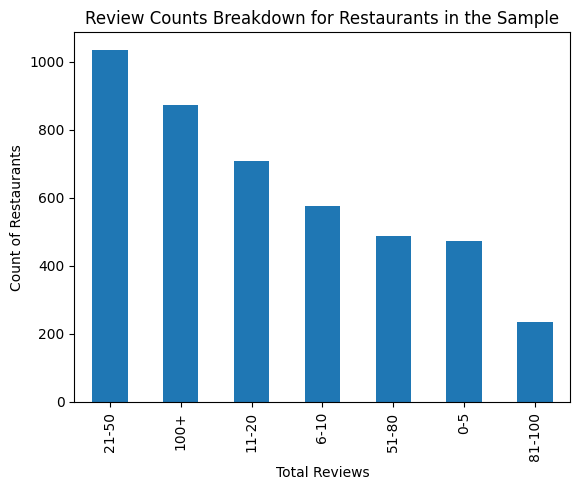

In [23]:
ids_array = reviews_sample.groupby("business_id")["review_id"].nunique()
(pd.cut(ids_array,bins = [0,5,10,20,50,80,100,np.inf],labels = ["0-5","6-10","11-20","21-50","51-80","81-100","100+"])
 .value_counts()
 .plot(kind = "bar",title = "Review Counts Breakdown for Restaurants in the Sample",xlabel = "Total Reviews",ylabel = "Count of Restaurants")\
)

In [24]:
selected_ids = ids_array[ids_array > 100].sample(10,random_state = 5).index.tolist()
reviews_df = reviews_sample[reviews_sample["business_id"].isin(selected_ids)]
print("Restaurants Selected for RAG Demo:")
reviews_df[["name","city","state"]].drop_duplicates(subset = "name").reset_index(drop = True)

Restaurants Selected for RAG Demo:


,name,city,state
0,Maggie Mae's Sunrise Cafe,Clearwater Beach,FL
1,Spasso Italian Grill,Media,PA
2,Ants Pants Café,Philadelphia,PA
3,Mellow Mushroom - Brandon,Brandon,FL
4,Cheddar's Scratch Kitchen,Fairview Heights,IL
5,Nook A Paleo Influenced Diner,Indianapolis,IN
6,Backspace Bar & Kitchen,New Orleans,LA
7,Aldertos Fresh Mexican Food,Reno,NV
8,Gusto Osteria,Tucson,AZ
9,French Toast,New Orleans,LA


<Axes: title={'center': 'Review Counts for Each Restaurant in the Final Sample'}, xlabel='name'>

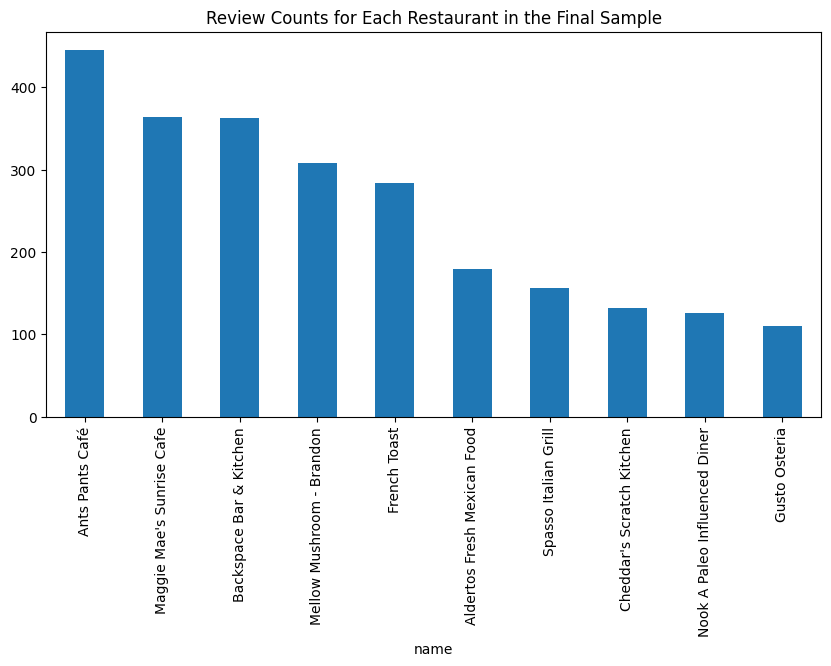

In [25]:
(reviews_df.groupby("name")["review_id"].nunique().sort_values(ascending=False)
 .plot(kind = "bar",title = "Review Counts for Each Restaurant in the Final Sample",figsize = (10,5))
)

In [26]:
reviews_df.to_csv(sample_path_final)